# Virtual Water Gallery survey results analysis
This Jupyter Notebook, written in Python by Louise Arnal (Ouranos Inc., formerly University of Saskatchewan), is used to analyze survey responses and generate graphics for a manuscript currently under review at PLOS Climate (Arnal and Schuster-Wallace, 2024). The analysis focuses on responses from gallery visitors. For the project participants' surveys, a single plot is generated using data from a different Excel document (not shared). Due to ethical considerations, the actual data used for the manuscript are not shared. Instead, we provide a toy dataset to allow you to run the code but not to reproduce the exact manuscript results.

Arnal, L., & Schuster-Wallace, C. (2024). The Virtual Water Gallery: Art as a catalyst for transforming knowledge and behaviour in water and climate. https://doi.org/10.31223/X5WD78

## Load modules, define paths and functions

In [16]:
# Import required modules
import geopandas as gpd
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from scipy.stats import permutation_test # requires at least scipy v1.7.0
import seaborn as sns
import statsmodels.formula.api as smf

In [3]:
# Define paths
output_fig_path = "/path/to/where/figures/will/be/saved/"
survey_results_exceldoc = "toy_data.xlsx"

### Functions

In [3]:
def demog_plot_bar(data_df, code_df, column_label, title, path):
    """
    Generate and save a bar chart of demographic data.

    This function creates a bar chart based on the specified column from the data DataFrame.
    It uses a corresponding lookup table from the code DataFrame to map values to labels.
    Special handling is provided for specific column labels to replace certain codes with NaN.
    The chart is saved to the specified file path.

    Parameters:
    - data_df: DataFrame containing the demographic data.
    - code_df: DataFrame containing the lookup table with codes and labels.
    - column_label: String specifying the column in data_df to be analyzed.
    - title: String for the x-axis label of the bar chart.
    - path: String specifying the file path to save the generated plot.
    
    """
    
    # Reformat indices
    column_to_select = code_df.columns.get_loc(data_df[column_label].columns[0][1])    
    new_code_df = code_df.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(data_df[column_label].columns[0][1])
    
    if (column_label == 'Reflection_behaviours_WR') or (column_label == 'Reflection_behaviours_CC'):
        new_code_df = new_code_df.replace([99,666,888], np.nan)
        new_code_df = new_code_df[new_code_df.index != 99]
        new_code_df = new_code_df[new_code_df.index != 666]
        new_code_df = new_code_df[new_code_df.index != 888]
    else:
        new_code_df = new_code_df.replace([99,66,666,888], np.nan)
        new_code_df = new_code_df[new_code_df.index != 99]
        new_code_df = new_code_df[new_code_df.index != 66]
        new_code_df = new_code_df[new_code_df.index != 666]
        new_code_df = new_code_df[new_code_df.index != 888]
        
    codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()
    
    # Reformat data
    if (column_label == 'Reflection_behaviours_WR') or (column_label == 'Reflection_behaviours_CC'):
        new_data_df = data_df.replace([99,666,888], np.nan)
    else:
        new_data_df = data_df.replace([99,66,666,888], np.nan)
    new_data_df.columns = new_data_df.columns.droplevel([1,2])    
    new_data_df_counts = new_data_df[column_label].value_counts(sort=False).sort_index()
        
    # Reindex data if there are missing labels 
    diff_labels = list(set(new_code_df.index.values) - set(new_data_df_counts.index.values))
    if len(diff_labels) > 0:
        new_data_df_counts = new_data_df_counts.reindex(new_code_df.index.values, fill_value=np.nan)
    codes_dict = new_code_df.to_dict()[new_code_df.columns.values[0]]
    index_map = {v: i for i, v in enumerate(new_data_df_counts.index)}
    new_codes = sorted(codes_dict.items(), key=lambda pair: index_map[pair[0]])
    new_codes_list = [x[1] for x in new_codes]
    
    # Plot and save bar chart
    fig = new_data_df_counts.plot(kind='bar', color='k')
    if (column_label == 'Age') or (column_label == 'Reflection_behaviours_WR') or (column_label == 'Reflection_behaviours_CC'):
        fig.set_xticklabels(new_codes_list, rotation=0)
    else:
        fig.set_xticklabels(new_codes_list, rotation=35, ha='right')
    plt.title('')
    plt.ylabel('#')
    plt.xlabel(title)
    
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
def demog_plot_comparison(data_1_df, data_2_df, code_df, column_label, title, label_1, label_2, path):
    """
    Generate and save a comparative bar chart of demographic data from two data sources.

    This function creates a comparative bar chart based on a specified column from two DataFrames.
    It uses a corresponding lookup table from the code DataFrame to map values to labels. The
    function computes the percentage of each unique value in the specified column for both data
    sources, aligns them with the labels from the code DataFrame, and generates a comparative
    bar chart.

    Parameters:
    - data_1_df: DataFrame containing the first set of demographic data.
    - data_2_df: DataFrame containing the second set of demographic data.
    - code_df: DataFrame containing the lookup table with codes and labels.
    - column_label: String specifying the column in the data DataFrames to be analyzed.
    - title: String for the x-axis label of the bar chart.
    - label_1: String label for the first dataset in the legend.
    - label_2: String label for the second dataset in the legend.
    - path: String specifying the file path to save the generated plot.

    """
    
    # Reformat indices
    column_to_select = code_df.columns.get_loc(data_1_df[column_label].columns[0][1])
    new_code_df = code_df.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(data_1_df[column_label].columns[0][1])
    new_code_df = new_code_df.replace([99,66,666,888], np.nan)
    new_code_df = new_code_df[new_code_df.index != 99]
    new_code_df = new_code_df[new_code_df.index != 66]
    new_code_df = new_code_df[new_code_df.index != 666]
    new_code_df = new_code_df[new_code_df.index != 888]
    codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()
        
    # Reformat data
    new_data_1_df = data_1_df.replace([99,66,666,888], np.nan)
    new_data_1_df.columns = new_data_1_df.columns.droplevel([1,2])
    new_data_1_df_counts = new_data_1_df[column_label].value_counts(sort=False).sort_index()
    new_data_1_df_perc = new_data_1_df_counts / new_data_1_df_counts.sum() * 100
    new_data_2_df = data_2_df.replace([99,66,666,888], np.nan)
    new_data_2_df.columns = new_data_2_df.columns.droplevel([1,2])
    new_data_2_df_counts = new_data_2_df[column_label].value_counts(sort=False).sort_index()
    new_data_2_df_perc = new_data_2_df_counts / new_data_2_df_counts.sum() * 100
        
    # Reindex data if there are missing labels
    diff_1_labels = list(set(new_code_df.index.values) - set(new_data_1_df_perc.index.values))
    if len(diff_1_labels) > 0:
        new_data_1_df_perc = new_data_1_df_perc.reindex(new_code_df.index.values, fill_value=np.nan)
    diff_2_labels = list(set(new_code_df.index.values) - set(new_data_2_df_perc.index.values))
    if len(diff_2_labels) > 0:
        new_data_2_df_perc = new_data_2_df_perc.reindex(new_code_df.index.values, fill_value=np.nan)
        
    # Combine both datasets into a single Pandas DataFrame
    combined_df = pd.DataFrame({label_1: new_data_1_df_perc,label_2: new_data_2_df_perc}, index=new_data_1_df_perc.index)
    
    # Plot and save bar chart
    fig = combined_df.plot(kind='bar', color=['k','w'], hatch='/', edgecolor='k', figsize=(5,5))
    fig.set_xticklabels(codes, rotation=35, ha='right')
    plt.title('')
    plt.ylabel('%')
    plt.xlabel(title)
    plt.tight_layout()
    if column_label == "Post_attitude_CC" or column_label == "Post_attitude_WR":
        plt.ylim(0,50)
    elif column_label == "Likelihood_attending_future_events" or column_label == "Exhibit_effectiveness" or column_label == "ArtSci_effectiveness":
        plt.ylim(0,80)
    else:
        plt.ylim(0,100)
    plt.legend(loc='best')
    
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
def demog_plot_pie(data_df, code_df, column_label, title, hatches, path):
    """
    Generate and save a pie chart of demographic data.

    This function creates a pie chart based on the specified column from the data DataFrame.
    It uses a corresponding lookup table from the code DataFrame to map values to labels.
    Special handling is provided for specific column labels to replace certain codes with NaN.
    The chart is saved to the specified file path.

    Parameters:
    - data_df: DataFrame containing the demographic data.
    - code_df: DataFrame containing the lookup table with codes and labels.
    - column_label: String specifying the column in data_df to be analyzed.
    - title: String for the x-axis label of the pie chart.
    - path: String specifying the file path to save the generated plot.
    
    """
    
    # Reformat indices
    column_to_select = code_df.columns.get_loc(data_df[column_label].columns[0][1])
    new_code_df = code_df.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(data_df[column_label].columns[0][1])
    new_code_df = new_code_df.replace([99,66,666,888], np.nan)
    new_code_df = new_code_df[new_code_df.index != 99]
    new_code_df = new_code_df[new_code_df.index != 66]
    new_code_df = new_code_df[new_code_df.index != 666]
    new_code_df = new_code_df[new_code_df.index != 888]
    codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()
    
    # Reformat data
    new_data_df = data_df.replace([99,66,666,888], np.nan)
    new_data_df.columns = new_data_df.columns.droplevel([1,2])
    new_data_df_counts = new_data_df[column_label].value_counts(sort=False).sort_index()
        
    # Reindex data if there are missing labels
    diff_labels = list(set(new_code_df.index.values) - set(new_data_df_counts.index.values))
    if len(diff_labels) > 0:
        new_data_df_counts = new_data_df_counts.reindex(new_code_df.index.values, fill_value=np.nan)
    for i in range(len(new_data_df_counts.index)):
        new_data_df_counts = new_data_df_counts.rename(index={i+1:list(codes)[i]})
        
    # Plot and save pie chart
    fig = new_data_df_counts.plot(kind='pie', cmap='binary', legend=True, autopct='%1.0f%%', pctdistance=1.15, labels=['']*len(new_data_df_counts.index), wedgeprops={'alpha':1,'edgecolor':'k','linewidth':1})
    elem = -1
    for patch in fig.patches:
        elem += 1
        patch.set_hatch(hatches[elem])
    plt.ylabel('')
    plt.xlabel('')
    plt.legend(bbox_to_anchor=(1,.95), loc='upper left', labels=new_data_df_counts.index, fontsize=9, title=title)
    plt.title('')
    plt.tight_layout()
    
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
def MannWhitney_U_test(sample1, sample2):
    """
    Perform the Mann-Whitney U test to compare the distributions of two independent samples.

    This function conducts the Mann-Whitney U test, a non-parametric test used to determine whether
    there is a significant difference between the distributions of two independent samples. It compares
    the ranks of the values in both samples and returns the test statistic and p-value.
    For more information: https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php

    Parameters:
    - sample1: Array-like, the first independent sample.
    - sample2: Array-like, the second independent sample.

    The function prints the result of the hypothesis test:
    - If the p-value is less than the significance level (alpha = 0.05), it rejects the null hypothesis,
      indicating that the distributions of the two samples are significantly different.
    - If the p-value is greater than or equal to the significance level, it fails to reject the null hypothesis,
      indicating that there is no significant difference between the distributions of the two samples.

    Returns:
    - statistic: The test statistic for the Mann-Whitney U test.
    - p_value: The p-value for the Mann-Whitney U test.
    """
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(sample1, sample2)

    if p_value < 0.05:
        print("Reject null hypothesis: The distributions are significantly different.")
    else:
        print("Fail to reject null hypothesis: The distributions are not significantly different.")
    
    return statistic, p_value

In [28]:
def permutation_test_for_statsig(data_df, var_of_interest, statistic, n_resamples=1000):
    """
    Perform permutation tests to estimate the statistical significance of correlations with a specified variable.

    This function conducts permutation tests to evaluate the statistical significance of correlations
    between a specified variable of interest and other columns in the provided DataFrame. For each column,
    it computes a p-value using a permutation test with the specified number of resamples. It returns a dictionary
    with column names as keys and their corresponding p-values from the permutation test as values.

    Parameters:
    - data_df: DataFrame containing the data for analysis.
    - var_of_interest: String, the name of the column to test correlations against.
    - statistic: Function, the statistical test to apply (e.g., a function that calculates the Spearman correlation).
    - n_resamples: Integer, the number of resamples to perform for the permutation test (default is 1000).

    Returns:
    - permutation_pvalues_dict: Dictionary with column names as keys and p-values from the permutation tests as values.
    """
    
    # Dictionary to store p-values from permutation tests
    permutation_pvalues_dict = {}
    
     # Iterate over all columns except the specified variable of interest
    for v in data_df.columns:
        if v != var_of_interest:
        
            x = data_df[v].values
            y = data_df[var_of_interest].values

            # Perform permutation test - explore all possible pairings by permuting `x`
            ref = stats.permutation_test((x,y), statistic, n_resamples=n_resamples, alternative='two-sided', permutation_type='pairings', random_state=0)

            # Store the p-value in the dictionary
            permutation_pvalues_dict[v] = ref.pvalue
    
    return permutation_pvalues_dict

In [29]:
def spearman_rank_corr(x,y):  
    """
    Calculate the Spearman correlation coefficient between two arrays.

    This function computes the Spearman correlation coefficient between two arrays, ignoring the p-value.

    Parameters:
    - x: Array-like, the first set of observations.
    - y: Array-like, the second set of observations.

    Returns:
    - rs: Float, the Spearman correlation coefficient between the two arrays.
    """
    
    rs = stats.spearmanr(x,y).correlation
    
    return rs

In [8]:
def summary_table(data_df, code_df, column_label):
    """
    Generate a summary table of counts for a specified column in the DataFrame, using a code lookup table for labels.

    This function creates a summary table that counts the occurrences of unique values in a specified column
    of the provided DataFrame. It uses a corresponding lookup table from the code DataFrame to map values
    to labels, ensuring that the summary table has meaningful labels.

    Parameters:
    - data_df: DataFrame containing the data for analysis.
    - code_df: DataFrame containing the lookup table with codes and labels.
    - column_label: String specifying the column in the data DataFrame to be analyzed.

    Returns:
    - df: DataFrame with the counts of unique values in the specified column, indexed by their corresponding labels.
    """
    
    # Reformat indices
    column_to_select = code_df.columns.get_loc(data_df[column_label].columns[0][1])    
    new_code_df = code_df.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(data_df[column_label].columns[0][1])
    codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()

    # Reformat data and count the occurrences of each unique value in the specified column
    new_data_df = data_df.copy()
    new_data_df.columns = new_data_df.columns.droplevel([1,2])    
    new_data_df_counts = new_data_df[column_label].value_counts(sort=False).sort_index()

    # Reindex data if there are missing labels
    diff_labels = list(set(new_code_df.index.values) - set(new_data_df_counts.index.values))
    if len(diff_labels) > 0:
        new_data_df_counts = new_data_df_counts.reindex(new_code_df.index.values, fill_value=np.nan)

    # Map the codes to labels and create a new DataFrame with the labels as the index and the counts as the column
    codes_dict = new_code_df.to_dict()[new_code_df.columns.values[0]]
    index_map = {v: i for i, v in enumerate(new_data_df_counts.index)}
    new_codes = sorted(codes_dict.items(), key=lambda pair: index_map[pair[0]])
    new_codes_list = [x[1] for x in new_codes]
    df = pd.DataFrame(data=new_data_df_counts.values, index=new_codes_list, columns=[column_label])
    
    return df

## Read and reformat survey results

In [5]:
# Load the survey results stored in an Excel document into a Pandas DataFrame
survey_results = pd.read_excel(survey_results_exceldoc, sheet_name="coded_survey_answers", header=[0,1,2], index_col=0)

display(survey_results.head())

Survey ID #,Virtual/Person,BINARY: Virtual/Person,Pre/Post Survey,Do you live in Canada?,"If you live in Canada, please provide the first three digits of your postal code","If you live outside Canada, please provide the name of the country where you currently reside","BINARY CANADA (1) NOT (0): If you live outside Canada, please provide the name of the country where you currently reside","BINARY HIGH INCOME (1) NOT (0): If you live outside Canada, please provide the name of the country where you currently reside",How do you identify?,How old are you?,...,"BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Supporting conservation or biodiversity efforts","Now that you have experienced the exhibit, how likely are you to engage in: Educating others on climate change and climate action","BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Educating others on climate change and climate action","Now that you have experienced the exhibit, how likely are you to engage in: Joining climate action rallies or climate change demonstrations","BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Joining climate action rallies or climate change demonstrations","Now that you have experienced the exhibit, how likely are you to engage in: Other","Do you have any comments you would like to share regarding the exhibit? (for example, the choice of art pieces exhibited, the art-science descriptions etc.)","BINARY: Do you have any comments you would like to share regarding the exhibit? (for example, the choice of art pieces exhibited, the art-science descriptions etc.)",Is there anything else that you would like to share about your experience?,BINARY: Is there anything else that you would like to share about your experience?
,Unnamed: 1_level_1,Column CA codes,Unnamed: 3_level_1,General codes,Column D codes,Column G codes,Column CA codes,Column CA codes,Column J codes,Column M codes,...,Column CA codes,Column AZ codes,Column CA codes,Column AZ codes,Column CA codes,Column BR codes,Column BU codes,Column CA codes,Column BX codes,Column CA codes
,Codes_28,Codes_27,Unnamed: 3_level_2,Codes_1,Codes_2,Codes_3,Codes_27,Codes_27,Codes_4,Codes_5,...,Codes_27,Codes_18,Codes_27,Codes_18,Codes_27,Codes_24,Codes_25,Codes_27,Codes_26,Codes_27
1,V,0,Pre,99,99,99,0,99,99,99,...,888,888,888,888,888,99,99,99,99,99
2,V,0,Pre,1,1,19,1,1,1,3,...,1,5,1,3,0,99,99,99,99,99
3,V,0,Pre,1,2,19,1,1,2,3,...,1,4,1,2,0,1,99,99,99,99
4,V,0,Pre,1,3,19,1,1,1,2,...,888,888,888,888,888,99,99,99,99,99
5,V,0,Pre,1,4,19,1,1,2,2,...,1,5,1,5,1,99,1,1,99,99


In [6]:
# Load the lookup table containing codes for the survey results, which are saved in a different sheet of the same Excel document, into a Pandas DataFrame
look_up_tables = pd.read_excel(survey_results_exceldoc, sheet_name="codes_python")

display(look_up_tables.head())

,General,Codes_1,Postal code,Codes_2,Country,Codes_3,Gender identification,Codes_4,Age bracket,Codes_5,...,Anything else that you would like to share about your experience,Codes_26,Changes (All),Codes_27,Attendance,Codes_28,Grouped feelings,Codes_29,Feelings,Codes_30
0,missing,99.0,T1W,1,France,1.0,Man,1.0,18-24,1.0,...,prior knowledge,1.0,Positive,1.0,Virtual,V,Same as usual,1.0,Negative,0.0
1,don't know,66.0,S7L,2,Germany,2.0,Woman,2.0,25-34,2.0,...,Positive reaction,2.0,Negative or neutral,0.0,In person,P,"Happy, excited",2.0,Neutral,1.0
2,question not asked (virtual/in-person differen...,666.0,S7N,3,United States of America,3.0,"Gender-fluid, non-binary and/or Two-Spirit",3.0,35-44,3.0,...,More,3.0,Mixed,3.0,NaN,NaN,"Uplifted, empowered, connected, supported",3.0,Mixed but positive,2.0
3,not applicable,888.0,S7H,4,Poland,4.0,Prefer not to say,4.0,45-54,4.0,...,innovative,7.0,NaN,NaN,NaN,NaN,"Worried, anxious, overwhelmed",4.0,Positive,3.0
4,yes,1.0,T2X,5,Switzerland,5.0,NaN,NaN,55-64,5.0,...,art as comms,9.0,NaN,NaN,NaN,NaN,"Inspired, interested, reflective, curious",5.0,NaN,NaN


In [7]:
# Rename the pre-survey results columns for reading and plotting 
pre_survey_results = survey_results.iloc[:,0:21]
pre_survey_results = pre_survey_results.rename(columns={'Virtual/Person': 'Attendance',
                                                        'BINARY: Virtual/Person':'Attendance_binary',
                                                        'Pre/Post Survey': 'Survey_type',
                                                        'Do you live in Canada?': 'Canada',
                                                        'If you live in Canada, please provide the first three digits of your postal code': 'Canada_postcode',
                                                        'If you live outside Canada, please provide the name of the country where you currently reside': 'Country_of_residence',
                                                        'BINARY CANADA (1) NOT (0): If you live outside Canada, please provide the name of the country where you currently reside': 'Canada_binary',
                                                        'BINARY HIGH INCOME (1) NOT (0): If you live outside Canada, please provide the name of the country where you currently reside': 'High_income_country_binary',
                                                        'How do you identify?': 'Gender',
                                                        'How old are you?': 'Age',
                                                        'What educational qualifications have you achieved? (Highest education)': 'Highest_education',
                                                        'What educational qualifications have you achieved? (Land-based learning and traditional knowledge)':'Landbased_learning',
                                                        'What is your annual household income, before taxes?': 'Gross_income',
                                                        'How would you rate your current level of knowledge about the consequences of climate change?':'Prior_knowledge_CC',
                                                        'BINARY: How would you rate your current level of knowledge about the consequences of climate change?':'Prior_knowledge_CC_binary',
                                                        'How would you rate your current level of knowledge about the impacts of climate change on our water resources?':'Prior_knowledge_WR',
                                                        'BINARY: How would you rate your current level of knowledge about the impacts of climate change on our water resources?':'Prior_knowledge_WR_binary',
                                                        'Have you ever experienced flooding where you live / have lived?': 'Flood_experience',
                                                        'Have you ever experienced drought where you live / have lived?': 'Drought_experience',
                                                        'Do you engage in actions to reduce the impact of climate change?': 'Engagement_in_actions_CCimpact_reduction',
                                                        'If yes, what types of actions do you engage in?': 'Types_actions_CCimpact_reduction'})

In [8]:
# Rename the post-survey results columns for reading and plotting
post_survey_results = survey_results.iloc[:,22::]
post_survey_results = post_survey_results.rename(columns={'Did the exhibit change your attitude towards climate change?':'Post_attitude_CC',
                                                          'BINARY: Did the exhibit change your attitude towards climate change?':'Post_attitude_CC_binary',
                                                          'Did the exhibit change your attitude towards our water resources?':'Post_attitude_WR',
                                                          'BINARY: Did the exhibit change your attitude towards our water resources?':'Post_attitude_WR_binary',
                                                          'How would you rate your current level of knowledge about the consequences of climate change? (choose the description that best fits)':'Post_knowledge_CC',
                                                         'How would you rate your current level of knowledge about the impacts of climate change on our water resources? (choose the description that best fits)':'Post_knowledge_WR',
                                                         'BINARY: How would you rate your current level of knowledge about the consequences of climate change? (choose the description that best fits)':'Post_knowledge_CC_binary',
                                                         'BINARY: How would you rate your current level of knowledge about the impacts of climate change on our water resources? (choose the description that best fits)':'Post_knowledge_WR_binary',
                                                         'Do you feel that your level of knowledge has changed as a result of the exhibit?':'Knowledge_change',
                                                         'How has your level of knowledge changed as a result of the exhibit? (Check all that apply)':'How has your level of knowledge changed as a result of the exhibit?',
                                                         'Has the exhibit caused you to reflect on your current behaviours regarding climate change mitigation?':'Reflection_behaviours_CC',
                                                         'Has the exhibit caused you to reflect on your current behaviours regarding water-related climate change mitigation?':'Reflection_behaviours_WR',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Energy conservation at home':'Energy_conservation_home_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Energy conservation at work':'Energy_conservation_work_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Water conservation at home':'Water_conservation_home_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Water conservation at work':'Water_conservation_work_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Composting':'Composting_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Recycling':'Recycling_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Eating less meat':'Eating_less_meat_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Walking and biking as much as possible':'Walking_biking_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Using renewable energy':'Renewable_energy_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Driving an electric vehicle':'Driving_electric_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Supporting conservation or biodiversity efforts':'Supporting_conservation_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Educating others on climate change and climate action':'Educating_others_binary',
                                                         'BINARY: Now that you have experienced the exhibit, how likely are you to engage in: Joining climate action rallies or climate change demonstrations':'Joining_demonstrations_binary',
                                                         'GROUPED: How did you feel when you completed the exhibit?':'Post_feeling',
                                                         'POS NEG NEU MIXED: How did you feel when you completed the exhibit?':'Post_feeling_binary',
                                                         'How effective was the exhibit in communicating the science behind the climate-water connection?':'Exhibit_effectiveness',
                                                         'BINARY: How effective was the exhibit in communicating the science behind the climate-water connection?':'Exhibit_effectiveness_binary',
                                                         'How effective is art at communicating science in general?':'ArtSci_effectiveness',
                                                         'BINARY: How effective is art at communicating science in general?':'ArtSci_effectiveness_binary',
                                                         'Do you think that more scientists should collaborate with artists to communicate their research?':'More_ArtSci_collab',
                                                         'How likely are you to attend another science-art exhibit in the future?':'Likelihood_attending_future_events',
                                                         'BINARY: How likely are you to attend another science-art exhibit in the future?':'Likelihood_attending_future_events_binary',
                                                         'Have you viewed other science-art exhibitions previously?':'Pre_experience_ArtSci'})

In [11]:
# Reformat pre-survey results for virtual vs. in person plots
pre_survey_results_forplotting = pre_survey_results.replace([99,66,666,888], np.nan)
pre_survey_results_forplotting.columns = pre_survey_results_forplotting.columns.droplevel([1,2])

virtual_mask = pre_survey_results_forplotting[pre_survey_results_forplotting['Attendance_binary'] == 0]
person_mask = pre_survey_results_forplotting[pre_survey_results_forplotting['Attendance_binary'] == 1]

virtual_forplotting_pre = pre_survey_results.loc[virtual_mask.index].replace([99,66,666,888], np.nan)
person_forplotting_pre = pre_survey_results.loc[person_mask.index].replace([99,66,666,888], np.nan)

# Reformat post-survey results for virtual vs. in person plots
post_survey_results_forplotting = post_survey_results.replace([99,66,666,888], np.nan)
post_survey_results_forplotting.columns = post_survey_results_forplotting.columns.droplevel([1,2])

virtual_forplotting_post = post_survey_results.loc[virtual_mask.index].replace([99,66,666,888], np.nan)
person_forplotting_post = post_survey_results.loc[person_mask.index].replace([99,66,666,888], np.nan)

In [12]:
# Prepare a Pandas DataFrame including the variables of interest for the analyses

# Extract variables of interest in the pre- and the post-surveys
variables_pre = pre_survey_results[['Prior_knowledge_CC','Prior_knowledge_WR','Age','Highest_education','Attendance_binary','Gender','Flood_experience','Drought_experience']]
variables_post_one = post_survey_results[['Knowledge_change','Reflection_behaviours_CC','Reflection_behaviours_WR']].replace(2,0)
variables_post_two = post_survey_results[['Post_attitude_CC','Post_attitude_WR','Post_attitude_CC_binary','Post_attitude_WR_binary','ArtSci_effectiveness','Post_feeling_binary','Exhibit_effectiveness_binary']]

# Merge all variables together and clean Pandas DataFrame
variables = pd.concat([variables_pre, variables_post_one, variables_post_two], axis=1)
variables = variables.replace([99,66,666,888], np.nan)
variables.columns = variables.columns.droplevel([1,2])

In [13]:
# Reformat pre-survey results for analyses for respondents with (without) sel-reported knowledge changes
post_survey_results_fortables = post_survey_results.copy()
post_survey_results_fortables.columns = post_survey_results_fortables.columns.droplevel([1,2])

knowchange_mask = post_survey_results_fortables[post_survey_results_fortables['Knowledge_change'] == 1]
noknowchange_mask = post_survey_results_fortables[post_survey_results_fortables['Knowledge_change'] == 2]

knowchange_fortables_post = post_survey_results.loc[knowchange_mask.index]
noknowchange_fortables_post = post_survey_results.loc[noknowchange_mask.index]

## Summary demographics

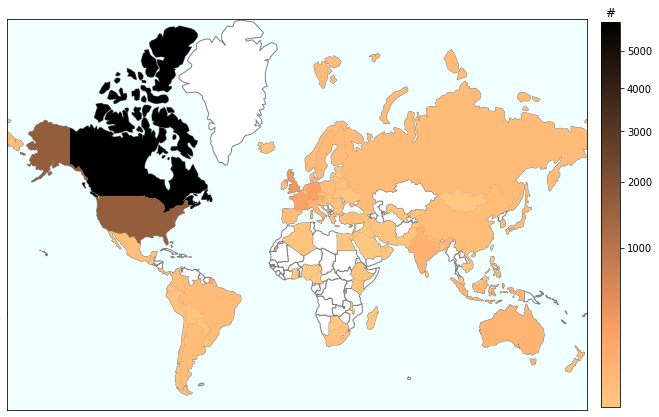

In [130]:
# Make map of website visits by countries

# Add base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('EPSG:3857')
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, linewidth=1, edgecolor='grey', color='white')

# Read data to plot - website visits between Mar 1, 2021 and Feb 3, 2024 taken from the Virtual Water Gallery traffic analytics
visits = {'Canada':5826,'United States of America':1635, 'United Kingdom':336, 'Germany':224, 'France':217, 
          'Netherlands':97, 'Austria':85, 'India':73, 'Australia':60, 'Switzerland':59, 'Indonesia':58, 'Italy':54,
          'Czechia':39, 'Sweden':39, 'Denmark':30, 'Japan':24, 'Spain':23, 'Finland':23, 'Greece':23, 'Brazil':22,
          'Russia':22, 'South Korea':21, 'Norway':21, 'New Zealand':19, 'Belgium':18, 'Colombia':18, 'Argentina':17,
          'Mexico':15, 'Turkey':15, 'Nepal':14, 'Ireland':12, 'Chile':11, 'Belarus':10, 'Poland':10, 'China':17,
          'Peru':8, 'Hungary':7, 'Iceland':7, 'Jordan':7, 'Portugal':7, 'Romania':7, 'South Africa':7,
          'United Arab Emirates':6, 'Costa Rica':6, 'Ethiopia':6, 'Slovenia':6, 'Iran':5, 'Kenya':5, 'Vietnam':5,
          'Algeria':4, 'Ecuador':4, 'Lebanon':4, 'Lithuania':4, 'Philippines':4, 'Pakistan':4, 'Puerto Rico':4,
          'Bulgaria':3, 'Egypt':3, 'Guatemala':3, 'Kyrgyzstan':3, 'Sri Lanka':3, 'Luxembourg':3, 'Bangladesh':2, 
          'Bolivia':2, 'Dominican Republic':2, 'Estonia':2, 'Ghana':2, 'Croatia':2, 'Iraq':2, 'Malaysia':2,
          'Panama':2, 'Singapore':2, 'Slovakia':2, 'Ukraine':2, 'Uruguay':2, 'Uzbekistan':2, 'Botswana':1,
          'Cameroon':1, 'Cyprus':1, 'Georgia':1, 'Israel':1, 'Cambodia':1, 'Kuwait':1, 'Latvia':1, 'Montenegro':1,
          'Madagascar':1, 'Mongolia':1, 'Malta':1, 'Malawi':1, 'Nigeria':1, 'Oman':1, 'Paraguay':1, 'Qatar':1,
          'Saudi Arabia':1, 'Trinidad and Tobago':1, 'Taiwan':1}

world_visits = world.copy()
world_visits['visits'] = world_visits['name'].map(visits)

# Plot results on a map
norm = mcolors.PowerNorm(gamma=0.5)  # Adjust gamma as needed
cmap = plt.cm.get_cmap('copper_r')
world_visits.plot(column='visits', cmap=cmap, norm=norm, legend=False, ax=ax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, shrink=0.55)
cb.ax.set_title('#')

ax.set_ylim(18500000, -8500000)
plt.gca().invert_yaxis()
ax.set_facecolor('azure')
plt.ticklabel_format(style = 'plain')
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()

# Save figure
plt.savefig(output_fig_path+"websitevisits_map.png", dpi=300, bbox_inches='tight')

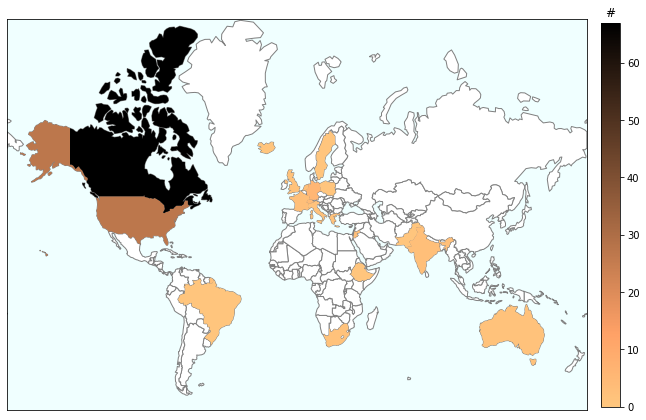

In [17]:
# Make map of respondents' country of residence

# Add base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('EPSG:3857')
ax = world.plot(figsize=(10,10), linewidth=1, edgecolor='grey', color='white')

# Read data to plot and exclude missing values (codes 99, 66, 666, 888 in the lookup table)
column_to_select = look_up_tables.columns.get_loc(pre_survey_results['Country_of_residence'].columns[0][1])    
new_code_df = look_up_tables.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(pre_survey_results['Country_of_residence'].columns[0][1])
new_code_df = new_code_df.replace([99,66,666,888], np.nan)
new_code_df = new_code_df[new_code_df.index != 99]
new_code_df = new_code_df[new_code_df.index != 66]
new_code_df = new_code_df[new_code_df.index != 666]
new_code_df = new_code_df[new_code_df.index != 888]
codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()
new_data_df = pre_survey_results.copy().replace([99,66,666,888], np.nan)    
new_data_df.columns = new_data_df.columns.droplevel([1,2])    

# Calculate sum and reformat to include all categories in the lookup table
new_data_df_counts = new_data_df['Country_of_residence'].value_counts(sort=False).sort_index()
diff_labels = list(set(new_code_df.index.values) - set(new_data_df_counts.index.values))
if len(diff_labels) > 0:
    new_data_df_counts = new_data_df_counts.reindex(new_code_df.index.values, fill_value=np.nan)

# Plot results on a map
cmap = plt.cm.get_cmap('copper_r')
img = plt.imshow(np.array([[np.nan,np.nan]]), cmap="copper_r", vmin=0, vmax=new_data_df_counts.max())
img.set_visible(False)
cb = plt.colorbar(orientation="vertical", pad=.02, shrink=.55)
cb.ax.set_title('#')

for i in range(len(new_data_df_counts.index)):
    country_name = list(codes)[i]
    rgba = cmap(new_data_df_counts.iloc[i]/new_data_df_counts.max())
    world[world['name']==country_name].plot(ax=ax, color=rgba)

ax.set_ylim(18500000, -8500000)
plt.gca().invert_yaxis()
ax.set_facecolor('azure')
plt.ticklabel_format(style = 'plain')
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()

# Save figure
plt.savefig(output_fig_path+"countryofresidence_map.png", dpi=300, bbox_inches='tight')

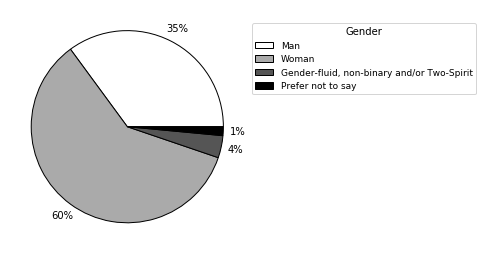

In [193]:
# Make pie plot of respondents' gender
demog_plot_pie(data_df=pre_survey_results, code_df=look_up_tables, column_label='Gender', title='Gender', hatches = ["", "", "", ""], path=output_fig_path+"gender_pieplot.png")

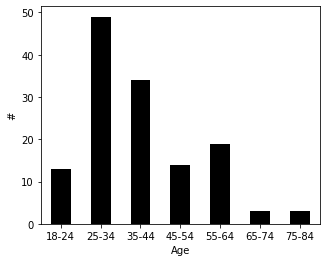

In [21]:
# Plot bar chart of respondents' age
demog_plot_bar(data_df=pre_survey_results, code_df=look_up_tables, column_label='Age', title='Age', path=output_fig_path+"age_barchart.png")

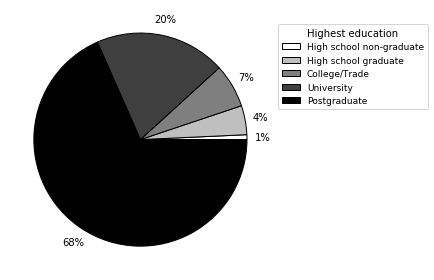

In [23]:
# Make pie plot of respondents' highest education
demog_plot_pie(data_df=pre_survey_results, code_df=look_up_tables, column_label='Highest_education', title='Highest education', hatches = ["", "", "", "", ""], path=output_fig_path+"education_pieplot.png")

## Knowledge changes
This part looks at changes in the respondents' knowledge levels and the factors that might influence them.

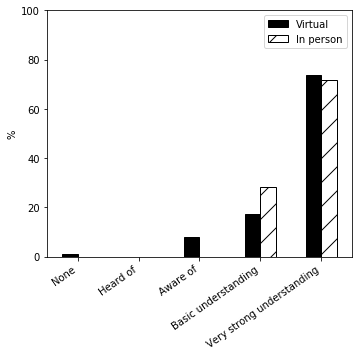

In [44]:
# Plot bar chart of respondents' prior knowledge of climate change (CC), split between virtual (V) vs. in person (P) participation
demog_plot_comparison(data_1_df=virtual_forplotting_pre, data_2_df=person_forplotting_pre, code_df=look_up_tables, column_label='Prior_knowledge_CC', title='', label_1='Virtual', label_2='In person', path=output_fig_path+"CCknowledge_VvsP_barchart_pre.png")

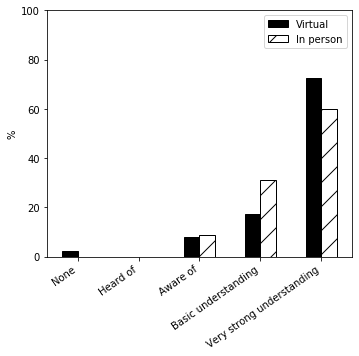

In [46]:
# Plot bar chart of respondents' prior knowledge of CC impacts on water resources WR, split between V vs. P participation
demog_plot_comparison(data_1_df=virtual_forplotting_pre, data_2_df=person_forplotting_pre, code_df=look_up_tables, column_label='Prior_knowledge_WR', title='', label_1='Virtual', label_2='In person',  path=output_fig_path+"WRknowledge_VvsP_barchart_pre.png")

In [271]:
# Check whether there are significant differences between the distributions of the prior CC knowledge levels for V vs. P participation with a Mann-Whitney U test
sample1 = virtual_forplotting_pre['Prior_knowledge_CC'].dropna().values
sample1 = [item for sublist in sample1 for item in sublist]
sample2 = person_forplotting_pre['Prior_knowledge_CC'].dropna().values
sample2 = [item for sublist in sample2 for item in sublist]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Fail to reject null hypothesis: The distributions are not significantly different.
Mann-Whitney U statistic: 1985.5
p-value: 0.46358548605323346


In [272]:
# Check whether there are significant differences between the distributions of the prior knowledge of CC impacts on water resources for V vs. P participation with a Mann-Whitney U test
sample1 = virtual_forplotting_pre['Prior_knowledge_WR'].dropna().values
sample1 = [item for sublist in sample1 for item in sublist]
sample2 = person_forplotting_pre['Prior_knowledge_WR'].dropna().values
sample2 = [item for sublist in sample2 for item in sublist]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Fail to reject null hypothesis: The distributions are not significantly different.
Mann-Whitney U statistic: 1751.5
p-value: 0.11438334673241796


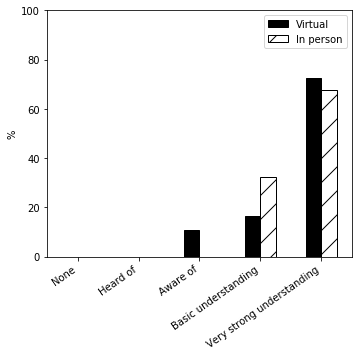

In [60]:
# Plot bar chart of respondents' post knowledge of CC, split between V vs. P participation
demog_plot_comparison(data_1_df=virtual_forplotting_post, data_2_df=person_forplotting_post, code_df=look_up_tables, column_label='Post_knowledge_CC', title='', label_1='Virtual', label_2='In person', path=output_fig_path+"CCknowledge_VvsP_barchart_post.png")

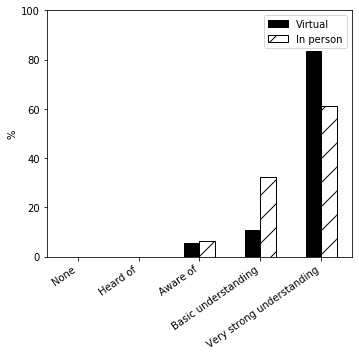

In [61]:
# Plot bar chart of respondents' post knowledge of CC impacts on water resources, split between V vs. P participation
demog_plot_comparison(data_1_df=virtual_forplotting_post, data_2_df=person_forplotting_post, code_df=look_up_tables, column_label='Post_knowledge_WR', title='', label_1='Virtual', label_2='In person',  path=output_fig_path+"WRknowledge_VvsP_barchart_post.png")

In [270]:
# Check whether there are significant differences between the distributions of the post CC knowledge levels for V vs. P participation with a Mann-Whitney U test
sample1 = virtual_forplotting_post['Post_knowledge_CC'].dropna().values
sample1 = [item for sublist in sample1 for item in sublist]
sample2 = person_forplotting_post['Post_knowledge_CC'].dropna().values
sample2 = [item for sublist in sample2 for item in sublist]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Fail to reject null hypothesis: The distributions are not significantly different.
Mann-Whitney U statistic: 840.0
p-value: 0.4460075443426038


In [262]:
# Check whether there are significant differences between the distributions of the post knowledge of CC impacts on water resources for V vs. P participation with a Mann-Whitney U test
sample1 = virtual_forplotting_post['Post_knowledge_WR'].dropna().values
sample1 = [item for sublist in sample1 for item in sublist]
sample2 = person_forplotting_post['Post_knowledge_WR'].dropna().values
sample2 = [item for sublist in sample2 for item in sublist]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Reject null hypothesis: The distributions are significantly different.
Mann-Whitney U statistic: 671.0
p-value: 0.014919520854471608


In [264]:
# Check whether there are significant differences between the prior and post CC knowledge levels of all participants, with a Mann-Whitney U test
sample1 = pre_survey_results['Prior_knowledge_CC'].replace([99,66,666,888], np.nan).values
sample1 = [item for sublist in sample1 for item in sublist if math.isnan(item) == False]
sample2 = post_survey_results['Post_knowledge_CC'].replace([99,66,666,888], np.nan).values
sample2 = [item for sublist in sample2 for item in sublist if math.isnan(item) == False]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Fail to reject null hypothesis: The distributions are not significantly different.
Mann-Whitney U statistic: 5937.5
p-value: 0.44922729907817144


In [267]:
# Check whether there are significant differences between the prior and post knowledge levels of CC impacts on water resources for all participants, with a Mann-Whitney U test
sample1 = pre_survey_results['Prior_knowledge_WR'].replace([99,66,666,888], np.nan).values
sample1 = [item for sublist in sample1 for item in sublist if math.isnan(item) == False]
sample2 = post_survey_results['Post_knowledge_WR'].replace([99,66,666,888], np.nan).values
sample2 = [item for sublist in sample2 for item in sublist if math.isnan(item) == False]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Fail to reject null hypothesis: The distributions are not significantly different.
Mann-Whitney U statistic: 5399.5
p-value: 0.07283546656769213


In [199]:
# Print self-reported knowledge change results
summary_table(data_df=post_survey_results, code_df=look_up_tables, column_label='Knowledge_change')

,Knowledge_change
missing,55.0
don't know,6.0
question not asked (virtual/in-person differences),NaN
not applicable,NaN
yes,36.0
no,49.0


In [235]:
# Print values associated with self-reported knowledge change
summary_table(data_df=post_survey_results, code_df=look_up_tables, column_label='How has your level of knowledge changed as a result of the exhibit?')

,How has your level of knowledge changed as a result of the exhibit?
Better understanding of the links between climate change and water,32.0
More confused about the links between climate change and water,NaN
No new information given,1.0
More aware of specific programs,1.0
Better understanding of biodiversity with glaciers,1.0
Better understanding of the link between scientific storytelling and artistic storytelling,1.0


In [236]:
# Print values associated with self-reported knowledge change only for respondents with self-reported change
summary_table(data_df=knowchange_fortables_post, code_df=look_up_tables, column_label='Did the exhibit change your opinion regarding climate change?')

,Did the exhibit change your opinion regarding climate change?
missing,NaN
don't know,2.0
question not asked (virtual/in-person differences),NaN
not applicable,NaN
yes,12.0
no,22.0


In [165]:
# Print values associated with self-reported knowledge change only for respondents with self-reported change
column_label = 'How did the exhibit change your opinion regarding climate change?'
code_df = look_up_tables.copy()
data_df = post_survey_results.copy()

column_to_select = code_df.columns.get_loc(data_df[column_label].columns[0][1])    
new_code_df = code_df.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(data_df[column_label].columns[0][1])
codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()

data_df.columns = data_df.columns.droplevel([1,2])  
data_df = data_df.loc[data_df['Knowledge_change'] == 1][column_label]
data = data_df.str.split(',', expand=True)
data = data.dropna().values.flatten()
data_df = pd.DataFrame(data=data)
new_data_df_counts = data_df[0].value_counts(sort=False).sort_index()
new_data_df_counts.index = new_data_df_counts.index.map(float)

diff_labels = list(set(new_code_df.index.values) - set(new_data_df_counts.index.values))
if len(diff_labels) > 0:
    new_data_df_counts = new_data_df_counts.reindex(new_code_df.index.values, fill_value=np.nan)

codes_dict = new_code_df.to_dict()[new_code_df.columns.values[0]]
index_map = {v: i for i, v in enumerate(new_data_df_counts.index)}
new_codes = sorted(codes_dict.items(), key=lambda pair: index_map[pair[0]])
new_codes_list = [x[1] for x in new_codes]

df = pd.DataFrame(data=new_data_df_counts.values, index=new_codes_list, columns=[column_label])
display(df)

,How did the exhibit change your opinion regarding climate change?
Art as comms,1.0
Connections,NaN
Urgency,2.0
Art as education,1.0
Awareness,NaN
Impact,1.0
More serious,NaN
Clarity,NaN
Personal perspectives,1.0
Human dimension,NaN


In [238]:
# Print values associated with self-reported knowledge change only for respondents with self-reported change
summary_table(data_df=knowchange_fortables_post, code_df=look_up_tables, column_label='Did the exhibit change your sense of urgency regarding climate change?')

,Did the exhibit change your sense of urgency regarding climate change?
missing,NaN
don't know,NaN
question not asked (virtual/in-person differences),NaN
not applicable,NaN
yes,16.0
no,20.0


In [167]:
# Print values associated with self-reported knowledge change only for respondents with self-reported change
column_label = 'How did the exhibit change your sense of urgency regarding climate change?'
code_df = look_up_tables.copy()
data_df = post_survey_results.copy()

column_to_select = code_df.columns.get_loc(data_df[column_label].columns[0][1])    
new_code_df = code_df.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(data_df[column_label].columns[0][1])
codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()

data_df.columns = data_df.columns.droplevel([1,2])  
data_df = data_df.loc[data_df['Knowledge_change'] == 1][column_label]
data = data_df.str.split(',', expand=True)
data = data.dropna().values.flatten()
data_df = pd.DataFrame(data=data)
new_data_df_counts = data_df[0].value_counts(sort=False).sort_index()
new_data_df_counts.index = new_data_df_counts.index.map(float)

diff_labels = list(set(new_code_df.index.values) - set(new_data_df_counts.index.values))
if len(diff_labels) > 0:
    new_data_df_counts = new_data_df_counts.reindex(new_code_df.index.values, fill_value=np.nan)

codes_dict = new_code_df.to_dict()[new_code_df.columns.values[0]]
index_map = {v: i for i, v in enumerate(new_data_df_counts.index)}
new_codes = sorted(codes_dict.items(), key=lambda pair: index_map[pair[0]])
new_codes_list = [x[1] for x in new_codes]

df = pd.DataFrame(data=new_data_df_counts.values, index=new_codes_list, columns=[column_label])
display(df)

,How did the exhibit change your sense of urgency regarding climate change?
Human narratives,NaN
Art as comms,2.0
Urgency,1.0
Emotions,NaN
Value (nature),NaN
Connections,2.0
Risk,NaN
Timescales,1.0
Solutions,NaN
Struggle,1.0


In [182]:
# Print values associated with self-reported knowledge change only for respondents with no self-reported change
column_label = 'How did the exhibit change your opinion regarding climate change?'
code_df = look_up_tables.copy()
data_df = post_survey_results.copy()

column_to_select = code_df.columns.get_loc(data_df[column_label].columns[0][1])    
new_code_df = code_df.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(data_df[column_label].columns[0][1])
codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()

data_df.columns = data_df.columns.droplevel([1,2])  
data_df = data_df.loc[data_df['Knowledge_change'] == 2][column_label]
data = data_df.dropna().values.flatten()
data_df = pd.DataFrame(data=data)
new_data_df_counts = data_df[0].value_counts(sort=False).sort_index()
new_data_df_counts.index = new_data_df_counts.index.map(float)

diff_labels = list(set(new_code_df.index.values) - set(new_data_df_counts.index.values))
if len(diff_labels) > 0:
    new_data_df_counts = new_data_df_counts.reindex(new_code_df.index.values, fill_value=np.nan)

codes_dict = new_code_df.to_dict()[new_code_df.columns.values[0]]
index_map = {v: i for i, v in enumerate(new_data_df_counts.index)}
new_codes = sorted(codes_dict.items(), key=lambda pair: index_map[pair[0]])
new_codes_list = [x[1] for x in new_codes]

df = pd.DataFrame(data=new_data_df_counts.values, index=new_codes_list, columns=[column_label])
display(df)

,How did the exhibit change your opinion regarding climate change?
Art as comms,NaN
Connections,1.0
Urgency,1.0
Art as education,NaN
Awareness,NaN
Impact,NaN
More serious,NaN
Clarity,NaN
Personal perspectives,NaN
Human dimension,NaN


In [183]:
# Print values associated with self-reported knowledge change only for respondents with no self-reported change
column_label = 'How did the exhibit change your sense of urgency regarding climate change?'
code_df = look_up_tables.copy()
data_df = post_survey_results.copy()

column_to_select = code_df.columns.get_loc(data_df[column_label].columns[0][1])    
new_code_df = code_df.iloc[:,[column_to_select-1,column_to_select]].dropna().set_index(data_df[column_label].columns[0][1])
codes = new_code_df.to_dict()[new_code_df.columns.values[0]].values()

data_df.columns = data_df.columns.droplevel([1,2])  
data_df = data_df.loc[data_df['Knowledge_change'] == 2][column_label]
data = data_df.str.split(',', expand=True)
data = data.dropna().values.flatten()
data_df = pd.DataFrame(data=data)
new_data_df_counts = data_df[0].value_counts(sort=False).sort_index()
new_data_df_counts.index = new_data_df_counts.index.map(float)

diff_labels = list(set(new_code_df.index.values) - set(new_data_df_counts.index.values))
if len(diff_labels) > 0:
    new_data_df_counts = new_data_df_counts.reindex(new_code_df.index.values, fill_value=np.nan)

codes_dict = new_code_df.to_dict()[new_code_df.columns.values[0]]
index_map = {v: i for i, v in enumerate(new_data_df_counts.index)}
new_codes = sorted(codes_dict.items(), key=lambda pair: index_map[pair[0]])
new_codes_list = [x[1] for x in new_codes]

df = pd.DataFrame(data=new_data_df_counts.values, index=new_codes_list, columns=[column_label])
display(df)

,How did the exhibit change your sense of urgency regarding climate change?
Human narratives,NaN
Art as comms,NaN
Urgency,NaN
Emotions,NaN
Value (nature),NaN
Connections,1.0
Risk,NaN
Timescales,NaN
Solutions,1.0
Struggle,NaN


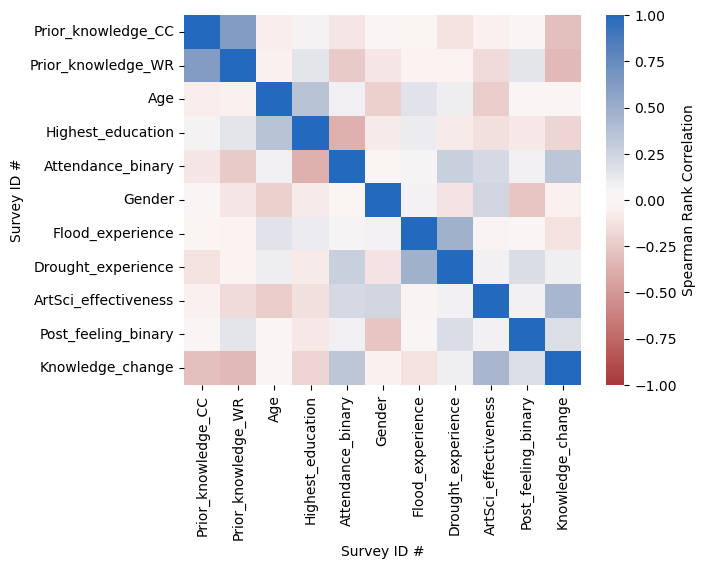

In [40]:
# Calculate correlations between self-reported knowledge change and the factors that might influence them

# Prepare variables of interest - make sure to read the variable we're interested in last for the permutation test
variables_knowchange = variables.copy()
variables_knowchange = variables_knowchange.filter(['Prior_knowledge_CC','Prior_knowledge_WR','Age','Highest_education','Attendance_binary','Gender','Flood_experience','Drought_experience','ArtSci_effectiveness','Post_feeling_binary','Knowledge_change'], axis=1)
variables_knowchange = variables_knowchange.dropna()

# Calculate and plot correlations matrix
cmap = sns.cm.vlag_r
corr_df = variables_knowchange.corr(method='spearman', min_periods=3)
ax = sns.heatmap(corr_df, annot=False, cmap=cmap, cbar_kws={'label': 'Spearman Rank Correlation'}, vmin=-1, vmax=1);

# Permutation test to estimate more robust statistical significance of correlations
permutation_knowchange_pvalues_dict = permutation_test_for_statsig(data_df=variables_knowchange, var_of_interest='Knowledge_change', statistic=spearman_rank_corr, n_resamples=1000)

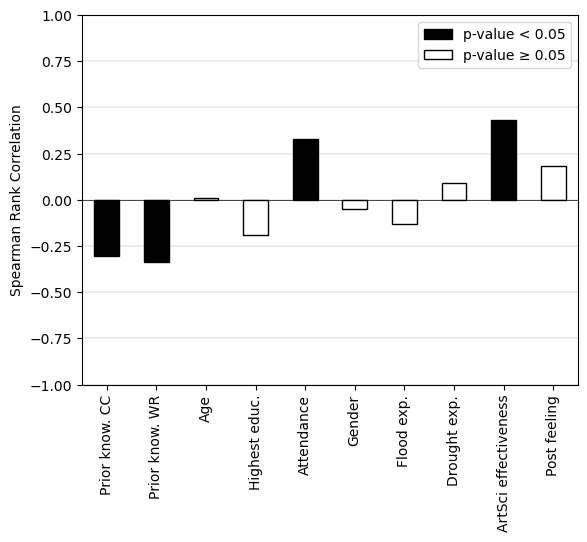

In [41]:
# Plot correlations and their statistical significance
colors = []
for p in permutation_knowchange_pvalues_dict:
    if permutation_knowchange_pvalues_dict[p] < 0.05:
        colors.append('k')
    else:
        colors.append('w')
        
labels = ['Prior know. CC', 'Prior know. WR', 'Age','Highest educ.','Attendance','Gender','Flood exp.','Drought exp.','ArtSci effectiveness','Post feeling']

fig = corr_df['Knowledge_change'][:-1].plot(kind='bar', color=tuple(colors), edgecolor='k')
plt.ylim(-1,1)
plt.ylabel('Spearman Rank Correlation')
plt.xlabel('')
plt.axhline(y=0,linewidth=.5, color='k')
fig.grid('on', which='major', axis='y', color='k', lw=.1)
fig.set_xticklabels(labels);
black_patch = mpatches.Patch(color='k', label='p-value < 0.05')
white_patch = mpatches.Patch(facecolor='w', edgecolor='k', label='p-value ≥ 0.05') 
plt.legend(handles=[black_patch,white_patch]);

plt.savefig(output_fig_path+"corr_knowledge_change", dpi=300, bbox_inches='tight')

## Attitude and behaviour changes
This part looks at changes in the respondents' attitudes and behaviours and the factors that might influence them.

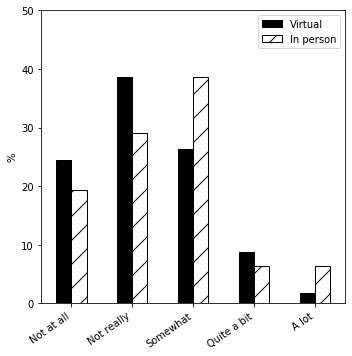

In [189]:
# Plot bar chart of respondents' self-reported attitude change towards CC, split between V vs. P participation
demog_plot_comparison(data_1_df=virtual_forplotting_post, data_2_df=person_forplotting_post, code_df=look_up_tables, column_label='Post_attitude_CC', title='', label_1='Virtual', label_2='In person',  path=output_fig_path+"CCattitude_VvsP_barchart_post.png")

In [273]:
# Check whether there are significant differences between the distributions of the self-reported attitude change towards CC for V vs. P participation with a Mann-Whitney U test
sample1 = virtual_forplotting_post['Post_attitude_CC'].dropna().values
sample1 = [item for sublist in sample1 for item in sublist]
sample2 = person_forplotting_post['Post_attitude_CC'].dropna().values
sample2 = [item for sublist in sample2 for item in sublist]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Fail to reject null hypothesis: The distributions are not significantly different.
Mann-Whitney U statistic: 758.0
p-value: 0.12686123452940318


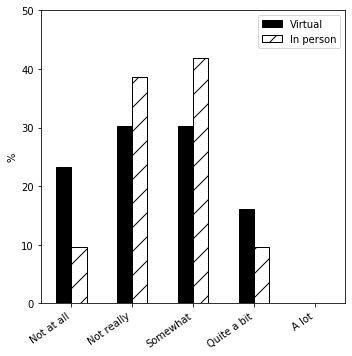

In [195]:
# Plot bar chart of respondents' self-reported attitude change towards CC impacts on water resources, split between V vs. P participation
demog_plot_comparison(data_1_df=virtual_forplotting_post, data_2_df=person_forplotting_post, code_df=look_up_tables, column_label='Post_attitude_WR', title='', label_1='Virtual', label_2='In person',  path=output_fig_path+"WRattitude_VvsP_barchart_post.png")

In [274]:
# Check whether there are significant differences between the distributions of the self-reported attitude change towards CC impacts on water resources for V vs. P participation with a Mann-Whitney U test
sample1 = virtual_forplotting_post['Post_attitude_WR'].dropna().values
sample1 = [item for sublist in sample1 for item in sublist]
sample2 = person_forplotting_post['Post_attitude_WR'].dropna().values
sample2 = [item for sublist in sample2 for item in sublist]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Fail to reject null hypothesis: The distributions are not significantly different.
Mann-Whitney U statistic: 803.5
p-value: 0.2764041479346012


In [239]:
# Print results for self-reported engagement in actions for CC impact reduction
summary_table(data_df=pre_survey_results, code_df=look_up_tables, column_label='Engagement_in_actions_CCimpact_reduction')

,Engagement_in_actions_CCimpact_reduction
missing,11.0
don't know,3.0
question not asked (virtual/in-person differences),NaN
not applicable,NaN
yes,120.0
no,12.0


In [240]:
# Print results for self-reported reflection on current behaviours regarding CC mitigation
summary_table(data_df=post_survey_results, code_df=look_up_tables, column_label='Reflection_behaviours_CC')

,Reflection_behaviours_CC
missing,55.0
don't know,4.0
question not asked (virtual/in-person differences),NaN
not applicable,NaN
yes,51.0
no,36.0


In [241]:
# Print results for self-reported reflection on current behaviours regarding water-related CC mitigation
summary_table(data_df=post_survey_results, code_df=look_up_tables, column_label='Reflection_behaviours_WR')

,Reflection_behaviours_WR
missing,57.0
don't know,8.0
question not asked (virtual/in-person differences),NaN
not applicable,NaN
yes,38.0
no,43.0


,pre,post
1,114,4.0
2,63,5.0
3,102,6.0
4,46,8.0
5,83,10.0
6,120,21.0
7,85,20.0
8,92,35.0
9,43,46.0
10,11,18.0


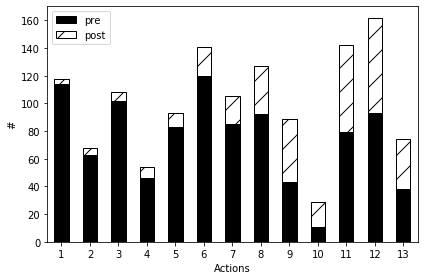

In [247]:
# Plot bar chart of actions for CC mitigation pre and post survey

# Reformat actions from the pre-survey results
actions_pre_df = pre_survey_results['Types_actions_CCimpact_reduction']
actions_pre_df = actions_pre_df.replace([99,66,666,888], np.nan)
actions_pre_df.columns = actions_pre_df.columns.droplevel([1])
actions_pre_df_expanded = actions_pre_df['Column AB codes'].str.split(',', expand=True)
actions_pre_df_expanded = actions_pre_df_expanded.replace('99',np.nan)

counts_actions_df = pd.value_counts(actions_pre_df_expanded.values.flatten())
counts_actions_df.index = counts_actions_df.index.astype(int)
counts_actions_df = counts_actions_df.sort_index()

# Reformat actions from the post-survey results
actions_post_df = post_survey_results[['Energy_conservation_home_binary','Energy_conservation_work_binary','Water_conservation_home_binary','Water_conservation_work_binary','Composting_binary','Recycling_binary','Eating_less_meat_binary','Walking_biking_binary','Renewable_energy_binary','Driving_electric_binary','Supporting_conservation_binary','Educating_others_binary','Joining_demonstrations_binary']].replace([99,66,666,888], np.nan)
actions_post_df.columns = actions_post_df.columns.droplevel([1,2])
counts_actions_post_df = actions_post_df.sum()
counts_actions_post_df = pd.Series(counts_actions_post_df.values, index=np.arange(1,len(counts_actions_post_df)+1))
actions_post_df.columns = np.arange(0,len(actions_post_df.columns))

# Combine pre and post actions
elem = 0
for i in actions_pre_df_expanded.index:
    elem += 1
    pre = pd.to_numeric(actions_pre_df_expanded.loc[i].fillna(0)).replace(np.arange(1,14),1)
    post = actions_post_df.loc[i].fillna(0)
    subtract = post - pre
    subtract_new = subtract.replace(-1,0)
    if elem == 1:
        count = subtract_new
    elif elem > 1:
        count += subtract_new
count.index += 1  

actions_compare_df = pd.concat([counts_actions_df,count],axis=1).rename(columns={0:"pre", 1:"post"})
display(actions_compare_df)

# Plot results - excluding the last one as it wasn't in the original survey
actions_compare_df = actions_compare_df.loc[np.arange(1,14)]
actions_compare_df.plot(kind='bar', color=['k','w'], hatch='/', edgecolor='k', rot=0, stacked=True)
plt.ylabel('#')
plt.xlabel('Actions')
plt.tight_layout();
plt.savefig(output_fig_path+"actions_prepost_barchart.png", dpi=300, bbox_inches='tight')

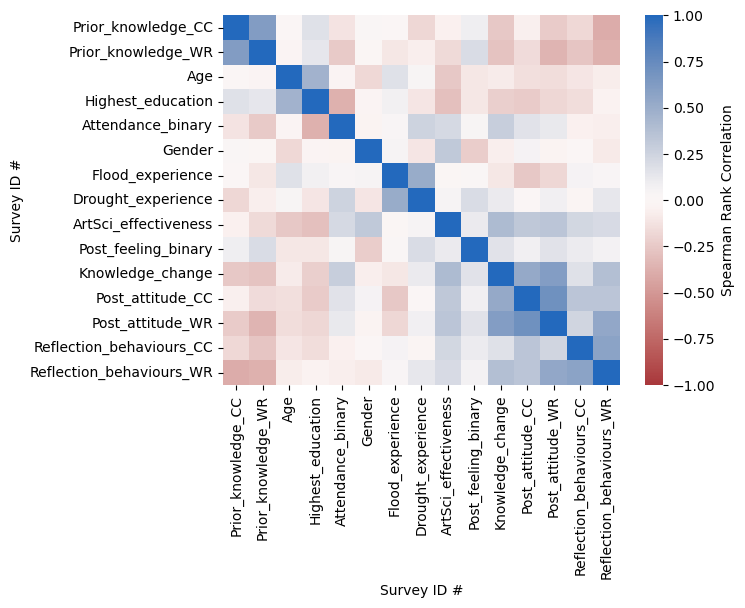

In [42]:
# Calculate correlations between reflection on behaviours towards CC mitigation with regards to water resources and the factors that might influence them

# Prepare variables of interest
variables_behavchange = variables.copy()
variables_behavchange = variables_behavchange.filter(['Prior_knowledge_CC','Prior_knowledge_WR','Age','Highest_education','Attendance_binary','Gender','Flood_experience','Drought_experience','ArtSci_effectiveness','Post_feeling_binary','Knowledge_change','Post_attitude_CC','Post_attitude_WR','Reflection_behaviours_CC','Reflection_behaviours_WR'], axis=1)
variables_behavchange = variables_behavchange.dropna()

# Calculate and plot correlations matrix
cmap = sns.cm.vlag_r
corr_df = variables_behavchange.corr(method='spearman', min_periods=3)
ax = sns.heatmap(corr_df, annot=False, cmap=cmap, cbar_kws={'label': 'Spearman Rank Correlation'}, vmin=-1, vmax=1);

# Permutation test to estimate more robust statistical significance of correlations
permutation_behavchange_pvalues_dict = permutation_test_for_statsig(data_df=variables_behavchange, var_of_interest='Reflection_behaviours_WR', statistic=spearman_rank_corr, n_resamples=1000)

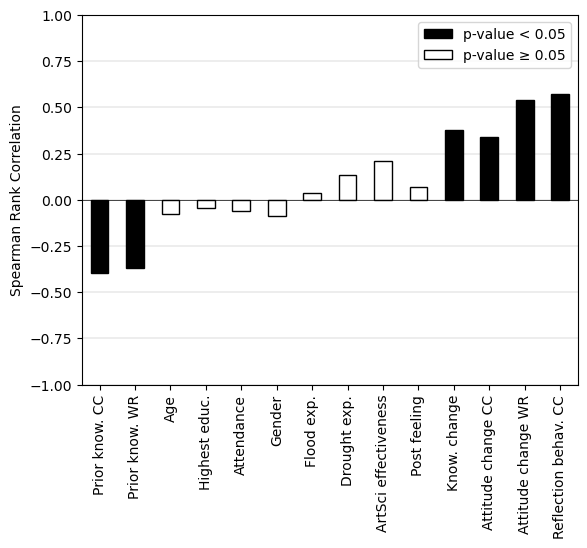

In [44]:
# Plot correlations and their statistical significance
colors = []
for p in permutation_behavchange_pvalues_dict:
    if permutation_behavchange_pvalues_dict[p] < 0.05:
        colors.append('k')
    else:
        colors.append('w')
        
labels = ['Prior know. CC', 'Prior know. WR', 'Age','Highest educ.','Attendance','Gender','Flood exp.','Drought exp.','ArtSci effectiveness','Post feeling','Know. change','Attitude change CC','Attitude change WR','Reflection behav. CC']

fig = corr_df['Reflection_behaviours_WR'][:-1].plot(kind='bar', color=tuple(colors), edgecolor='k')
plt.ylim(-1,1)
plt.ylabel('Spearman Rank Correlation')
plt.xlabel('')
plt.axhline(y=0,linewidth=.5, color='k')
fig.grid('on', which='major', axis='y', color='k', lw=.1)
fig.set_xticklabels(labels);
black_patch = mpatches.Patch(color='k', label='p-value < 0.05')
white_patch = mpatches.Patch(facecolor='w', edgecolor='k', label='p-value ≥ 0.05') 
plt.legend(handles=[black_patch,white_patch]);

plt.savefig(output_fig_path+"corr_behaviour_change", dpi=300, bbox_inches='tight')

# Art as comms
This part looks at respondents' perception of art as a tool for communication and the factors that might influence this.

In [16]:
# Print respondents' post-survey feelings
feelings_df = post_survey_results['Post_feeling']
feelings_df.columns = feelings_df.columns.droplevel([1])
feelings_df_expanded = feelings_df['Column CD codes'].str.split(',', expand=True)
feelings_df_expanded = feelings_df_expanded.replace([99,66,666,888], np.nan)

counts_feelings_df = pd.value_counts(feelings_df_expanded.values.flatten())
counts_feelings_df.index = counts_feelings_df.index.astype(int)
counts_feelings_df = counts_feelings_df.sort_index()
counts_feelings_df = counts_feelings_df.reset_index()
counts_feelings_df = counts_feelings_df.rename(columns={'index':'cat'})

codes = look_up_tables['How did you feel after the exhibit'].dropna()

pos = counts_feelings_df.loc[counts_feelings_df.cat.isin([2,3,5,7,8])].iloc[:,1].sum()
neut = counts_feelings_df.loc[counts_feelings_df.cat.isin([1,10])].iloc[:,1].sum()
neg = counts_feelings_df.loc[counts_feelings_df.cat.isin([4,6,9])].iloc[:,1].sum()

counts_feelings_pie = pd.Series([pos,neut,neg], index =['positive','neutral','negative']) 

display(counts_feelings_pie)

positive    88
neutral     24
negative    30
dtype: int64

In [64]:
# Reformat pre-survey results for analyses for respondents with positive or negative feelings from the exhibit
negfeelings_mask = post_survey_results_fortables[post_survey_results_fortables['Post_feeling_binary'] == 0]
posfeelings_mask = post_survey_results_fortables[post_survey_results_fortables['Post_feeling_binary'] == 3]

negfeelings_fortables_pre = pre_survey_results.loc[negfeelings_mask.index]
posfeelings_fortables_pre = pre_survey_results.loc[posfeelings_mask.index]

In [65]:
# Print demographics for respondents who reported feeling negative after the exhibit
summary_table(data_df=negfeelings_fortables_pre, code_df=look_up_tables, column_label='Gender')

,Gender
Man,2.0
Woman,9.0
"Gender-fluid, non-binary and/or Two-Spirit",NaN
Prefer not to say,1.0


In [67]:
# Print demographics for respondents who reported feeling negative after the exhibit
summary_table(data_df=posfeelings_fortables_pre, code_df=look_up_tables, column_label='Gender')

,Gender
Man,20.0
Woman,19.0
"Gender-fluid, non-binary and/or Two-Spirit",NaN
Prefer not to say,NaN


In [254]:
# Print results for respondents' ratings of the exhibit effectiveness
summary_table(data_df=post_survey_results, code_df=look_up_tables, column_label='Exhibit_effectiveness_binary')

,Exhibit_effectiveness_binary
Positive,65.0
Negative or neutral,22.0
Mixed,NaN


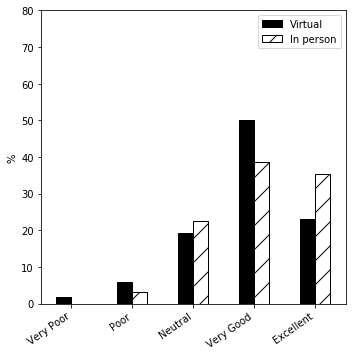

In [255]:
# Plot bar chart of respondents' assessment of the effectiveness of this exhibit in communicating the science behind the climate-water connection, split between V vs. P participation
demog_plot_comparison(data_1_df=virtual_forplotting_post, data_2_df=person_forplotting_post, code_df=look_up_tables, column_label='Exhibit_effectiveness', title='', label_1='Virtual', label_2='In person',  path=output_fig_path+"Exhibit_effectiveness_VvsP_barchart_post.png")

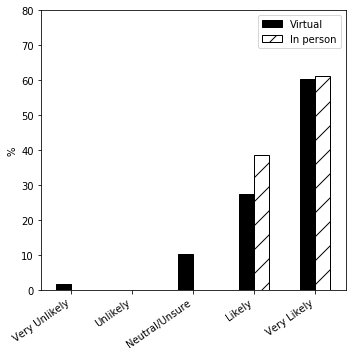

In [257]:
# Plot bar chart of respondents' likelihood to attend similar future events, split between V vs. P participation
demog_plot_comparison(data_1_df=virtual_forplotting_post, data_2_df=person_forplotting_post, code_df=look_up_tables, column_label='Likelihood_attending_future_events', title='', label_1='Virtual', label_2='In person',  path=output_fig_path+"Future_events_likelihood_VvsP_barchart_post.png")

In [275]:
# Check whether there are significant differences between the distributions of the exhibit's effectiveness for V vs. P participation with a Mann-Whitney U test
sample1 = virtual_forplotting_post['Exhibit_effectiveness'].dropna().values
sample1 = [item for sublist in sample1 for item in sublist]
sample2 = person_forplotting_post['Exhibit_effectiveness'].dropna().values
sample2 = [item for sublist in sample2 for item in sublist]

# Perform Mann-Whitney U test
statistic, p_value = MannWhitney_U_test(sample1, sample2)

print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Fail to reject null hypothesis: The distributions are not significantly different.
Mann-Whitney U statistic: 716.5
p-value: 0.18509829314758497


In [276]:
# Print results for respondents' thoughts on whether there should be more ArtSci collaborations
summary_table(data_df=post_survey_results, code_df=look_up_tables, column_label='More_ArtSci_collab')

,More_ArtSci_collab
missing,53.0
don't know,8.0
question not asked (virtual/in-person differences),NaN
not applicable,NaN
yes,84.0
no,1.0


In [277]:
# Print results for whether respondents have viewed other ArtSci exhibits previously
summary_table(data_df=post_survey_results, code_df=look_up_tables, column_label='Pre_experience_ArtSci')

,Pre_experience_ArtSci
missing,53.0
don't know,8.0
question not asked (virtual/in-person differences),NaN
not applicable,NaN
yes,45.0
no,12.0


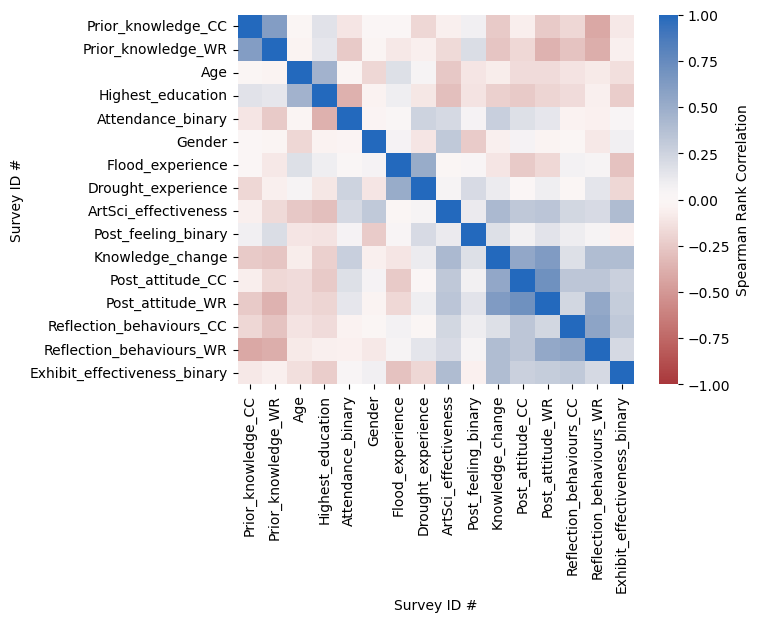

In [45]:
# Calculate correlations between exhibit effectiveness and the factors that might influence it

# Prepare variables of interest
variables_exhibiteffect = variables.copy()
variables_exhibiteffect = variables_exhibiteffect.filter(['Prior_knowledge_CC','Prior_knowledge_WR','Age','Highest_education','Attendance_binary','Gender','Flood_experience','Drought_experience','ArtSci_effectiveness','Post_feeling_binary','Knowledge_change','Post_attitude_CC','Post_attitude_WR','Reflection_behaviours_CC','Reflection_behaviours_WR','Exhibit_effectiveness_binary'], axis=1)
variables_exhibiteffect = variables_exhibiteffect.dropna()

# Calculate and plot correlations matrix
cmap = sns.cm.vlag_r
corr_df = variables_exhibiteffect.corr(method='spearman', min_periods=3)
ax = sns.heatmap(corr_df, annot=False, cmap=cmap, cbar_kws={'label': 'Spearman Rank Correlation'}, vmin=-1, vmax=1);

# Permutation test to estimate stat significance of correlations
permutation_exhibiteffect_pvalues_dict = permutation_test_for_statsig(data_df=variables_exhibiteffect, var_of_interest='Exhibit_effectiveness_binary', statistic=spearman_rank_corrstatistic, n_resamples=1000)

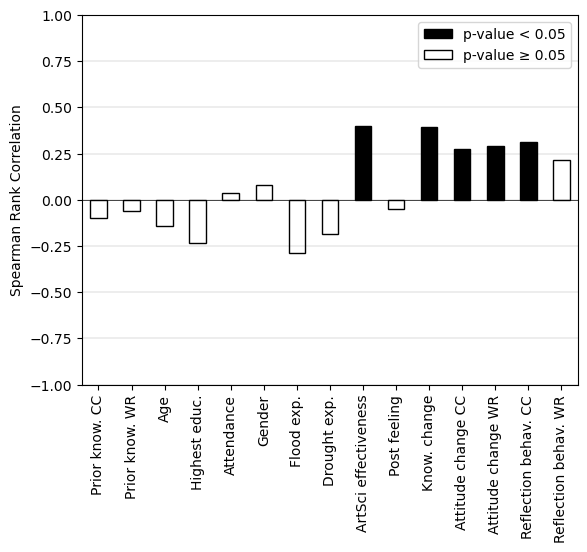

In [46]:
# Plot correlations and their statistical significance
colors = []
for p in permutation_exhibiteffect_pvalues_dict:
    if permutation_exhibiteffect_pvalues_dict[p] < 0.05:
        colors.append('k')
    else:
        colors.append('w')
        
labels = ['Prior know. CC', 'Prior know. WR', 'Age','Highest educ.','Attendance','Gender','Flood exp.','Drought exp.','ArtSci effectiveness','Post feeling','Know. change','Attitude change CC','Attitude change WR','Reflection behav. CC','Reflection behav. WR']

fig = corr_df['Exhibit_effectiveness_binary'][:-1].plot(kind='bar', color=tuple(colors), edgecolor='k')
plt.ylim(-1,1)
plt.ylabel('Spearman Rank Correlation')
plt.xlabel('')
plt.axhline(y=0,linewidth=.5, color='k')
fig.grid('on', which='major', axis='y', color='k', lw=.1)
fig.set_xticklabels(labels);
black_patch = mpatches.Patch(color='k', label='p-value < 0.05')
white_patch = mpatches.Patch(facecolor='w', edgecolor='k', label='p-value ≥ 0.05') 
plt.legend(handles=[black_patch,white_patch]);

plt.savefig(output_fig_path+"corr_exhibiteffectiveness", dpi=300, bbox_inches='tight')

## Project participants survey

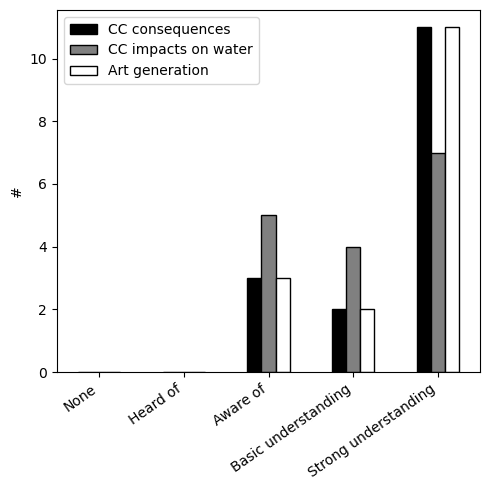

In [17]:
# Plot bar chart of project participants' knowledge of CC consequences, CC impacts on water, and art generation

# These data are taken from a different excel sheet
data_CC = [0,0,3,2,11]
data_WR = [0,0,5,4,7]
data_art = [0,0,3,2,11]
index = ['None','Heard of','Aware of','Basic understanding','Strong understanding']

data_df = pd.DataFrame({'CC consequences':data_CC, 'CC impacts on water':data_WR, 'Art generation':data_art}, index=index)

fig = data_df.plot(kind='bar', color=['k','grey','w'], edgecolor='k', figsize=(5,5))
fig.set_xticklabels(index, rotation=35, ha='right')
plt.title('')
plt.ylabel('#')
plt.tight_layout()
plt.legend(loc='best')

plt.savefig(output_fig_path+"Participants_VWG_knowledge.png", dpi=300, bbox_inches='tight')
plt.show()